In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import numpy as np
import jax
import jax.numpy as jnp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import diffrax as dfx
from typing import List

from functools import partial
import os
import sys

jax.config.update('jax_platform_name', 'gpu')

if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)


np.random.seed(0)
jax.devices()

[cuda(id=0)]

In [3]:
from synbio_morpher.srv.parameter_prediction.simulator import make_piecewise_stepcontrol
from synbio_morpher.utils.misc.type_handling import flatten_listlike
from synbio_morpher.utils.modelling.physical import eqconstant_to_rates, equilibrium_constant_reparameterisation
from synbio_morpher.utils.modelling.deterministic import bioreaction_sim_dfx_expanded
from synbio_morpher.utils.modelling.solvers import get_diffrax_solver, make_stepsize_controller, simulate_steady_states
from synbio_morpher.utils.results.analytics.timeseries import calculate_adaptation, compute_peaks, compute_adaptability_full


# Set up test circuits

In [4]:
def make_species_bound(species_unbound):
    return sorted(set(flatten_listlike([['-'.join(sorted([x, y])) for x in species_unbound] for y in species_unbound])))


# RNA circuit settings
species_unbound = ['RNA_0', 'RNA_1', 'RNA_2']
species_bound = make_species_bound(species_unbound)
species = species_unbound + species_bound
species_signal = ['RNA_0']
species_output = ['RNA_2']
# species_output = ['RNA_1', 'RNA_2']
species_nonsignal = [s for s in species_unbound if s not in species_signal]
idxs_signal = np.array([species.index(s) for s in species_signal])
idxs_output = np.array([species.index(s) for s in species_output])
idxs_unbound = np.array([species.index(s) for s in species_unbound])
idxs_bound = np.array([species.index(s) for s in species_bound])
signal_onehot = np.array([1 if s in idxs_signal else 0 for s in np.arange(len(species))])

# Dynamic Simulation parameters
k_a = 0.00150958097
signal_target = 2
t0 = 0
t1 = 500
ts = np.linspace(t0, t1, 500)
tmax = 1
dt0 = 0.005555558569638981
dt1_factor = 5
dt1 = dt0 * dt1_factor
max_steps = 16**4 * 10
use_sensitivity_func1 = False
sim_method = 'Dopri5'
stepsize_controller = 'adaptive'
threshold_steady_state = 0.01
batch_size = 100

# MC parameters
total_steps = 10
total_samples = 1000
choose_max = int(total_samples * 0.1)
diversity = 0.2  # Sensitivity max to add into next chosen circuits
mutation_scale = 0.1
n_circuits_display = 30
N0 = 200
y00 = np.array([[N0] * len(species_unbound) + [0] * len(species_bound)]).astype(np.float32)
y00 = np.repeat(y00, repeats=total_samples, axis=0)

# Reactions
energies = np.random.rand(total_samples, len(np.tril_indices(len(species_unbound))[0]))
energies = np.interp(energies, (energies.min(), energies.max()), (-25, 0))
eqconstants = jax.vmap(partial(equilibrium_constant_reparameterisation, initial=N0))(energies)
forward_rates, reverse_rates = eqconstant_to_rates(eqconstants, k_a)
# forward_rates = np.array(list(map(lambda r: r[np.triu_indices(len(species_unbound))], forward_rates)))
forward_rates = forward_rates[0]
# reverse_rates = np.array(list(map(lambda r: r[np.triu_indices(len(species_unbound))], reverse_rates)))

inputs = np.array([
    [2, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0, 0, 0],
    [1, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 2, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 2, 0, 0, 0, 0, 0, 0],
], dtype=np.float64)
outputs = np.array([
    [0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1],
], dtype=np.float64)

# Initialise simulations

In [5]:
sim_func = jax.jit(jax.vmap(
    partial(bioreaction_sim_dfx_expanded,
            t0=t0, t1=t1, dt0=dt0,
            forward_rates=forward_rates,
            inputs=inputs,
            outputs=outputs,
            solver=get_diffrax_solver(
                sim_method),
            saveat=dfx.SaveAt(
                ts=jnp.linspace(t0, t1, 500)),  # int(np.min([500, t1-t0]))))
            stepsize_controller=make_stepsize_controller(t0, t1, dt0, dt1,
                                                         choice=stepsize_controller)
            )))
# sol_steady_states = jax.vmap(bioreaction_sim_dfx_expanded)(y00, reverse_rates)
# y01 = np.array(sol_steady_states.ys[:, -1])
# y01[:, np.array(idxs_signal)] = y01[:, np.array(idxs_signal)] * signal_target
# sol_signal = jax.vmap(bioreaction_sim_dfx_expanded)(y01, reverse_rates)

# Monte Carlo iterations

In [6]:
def choose_next(sol, idxs_signal, idxs_output, use_sensitivity_func1: bool, choose_max: int, diversity=0.):
    """ Choose circuits with highest adaptability """
    
    def get_next_idxs(analytic, n_chosen):
        idxs_next = jnp.where(jnp.sort(jnp.nanmax(analytic[:, idxs_output], axis=1))[
                            -n_chosen:].min() <= analytic[:, idxs_output])[0]
        return idxs_next
    
    def get_next_idxs_diversity(choose_max, diversity):
        n_chosen_a = int(np.ceil(choose_max * (1 - diversity)))
        n_chosen_s = int(np.floor(choose_max * diversity))
        idxs_next_a, idxs_next_s = (jnp.array([]), jnp.array([]))
        if n_chosen_a:
            idxs_next_a = get_next_idxs(adaptability, n_chosen_a)
        if n_chosen_s:
            idxs_next_s = get_next_idxs(sensitivity, n_chosen_s)
        # idxs_next_p = get_next_idxs(precision, int(np.floor(choose_max * diversity / 2)))
        idxs_next = jnp.unique(jnp.concatenate([idxs_next_a, idxs_next_s]))
        if len(idxs_next) < choose_max:
            idxs_next = jnp.concatenate([idxs_next, get_next_idxs(adaptability, choose_max - len(idxs_next))])
        return idxs_next

    ys0, ys1 = sol
    adaptability, sensitivity, precision = jax.vmap(partial(
        compute_adaptability_full, idx_sig=idxs_signal, use_sensitivity_func1=use_sensitivity_func1))(ys0, ys1)
    # idxs_next = jnp.argsort(adaptability[:, idxs_output], axis=0)[-choose_max:]
    if diversity:
        idxs_next = get_next_idxs_diversity(choose_max, diversity)
    else:
        idxs_next = get_next_idxs(adaptability, choose_max)
        
    return idxs_next.astype(jnp.int32), adaptability, sensitivity, precision


def mutate_expand(parents: jnp.ndarray, n_samples_per_parent, mutation_scale):
    min_param = parents.min()
    # Generate mutated samples from each parent
    mutated = jax.tree_util.tree_map(
                            lambda x: x + x * mutation_scale * np.random.randn(n_samples_per_parent, *x.shape), parents)
    mutated_nonzero = jnp.where(mutated < min_param, min_param, mutated)

    return mutated_nonzero.reshape(mutated_nonzero.shape[0] * mutated_nonzero.shape[1], *mutated_nonzero.shape[2:])


def simulate(y00, reverse_rates, sim_func, t0, t1, tmax, batch_size, threshold):
    
    def join_results(xs, xsb):
        if xs is None:
            xs = xsb
        else:
            xs = jnp.concatenate([xs, xsb], axis=0)
        return xs
    
    ys0, ts0, ys1, ts1 = [None] * 4
    for i, batch_step in enumerate(range(0, len(reverse_rates), batch_size)):
        i0, i1 = batch_step, jnp.minimum(batch_step + batch_size, len(reverse_rates))
        print(f'Simulating batch {i}: {i0} to {i1}')
        y00b, reverse_rates_b = y00[i0:i1], reverse_rates[i0:i1]
        ys0b, ts0b, ys1b, ts1b = simulate_core(y00b, reverse_rates_b, sim_func, t0, t1, tmax, threshold)
        
        # for xs, xsb in zip([ys0, ts0, ys1, ts1], [ys0b, ts0b, ys1b, ts1b]):
        ys0 = join_results(ys0, ys0b)
        ts0 = join_results(ts0, ts0b)
        ys1 = join_results(ys1, ys1b)
        ts1 = join_results(ts1, ts1b)
    
    return ys0, ts0, ys1, ts1
    
    
def simulate_core(y00, reverse_rates, sim_func, t0, t1, tmax, threshold):
    ys0, ts0 = simulate_steady_states(
        y0=y00, total_time=tmax, sim_func=sim_func,
        t0=t0, t1=t1,
        threshold=threshold,
        reverse_rates=reverse_rates,
    )
    y01 = np.array(ys0[:, -1])
    y01[:, np.array(idxs_signal)] = y01[:, np.array(
        idxs_signal)] * signal_target
    ys1, ts1 = simulate_steady_states(
        y0=y01, total_time=tmax, sim_func=sim_func,
        t0=t0, t1=t1,
        threshold=threshold,
        reverse_rates=reverse_rates,
    )
    return ys0, ts0, ys1, ts1

In [7]:
y00.shape

(1000, 9)



Starting iteration 1 out of 10


Simulating batch 0: 0 to 100


Done:  0:00:30.799348


Done:  0:00:32.926232
Simulating batch 1: 100 to 200


Done:  0:00:32.833336


Done:  0:00:30.710265
Simulating batch 2: 200 to 300


Done:  0:00:37.414423


Done:  0:00:36.811065
Simulating batch 3: 300 to 400


Done:  0:00:34.726140


Done:  0:00:35.107367
Simulating batch 4: 400 to 500


Done:  0:00:32.193186


Done:  0:00:32.156235
Simulating batch 5: 500 to 600


Done:  0:00:31.717178


Done:  0:00:32.871891
Simulating batch 6: 600 to 700


Done:  0:00:28.526084


Done:  0:00:28.002222
Simulating batch 7: 700 to 800


Done:  0:00:32.735868


Done:  0:00:31.301215
Simulating batch 8: 800 to 900


Done:  0:00:36.795346


Done:  0:00:44.252456
Simulating batch 9: 900 to 1000


Done:  0:00:31.574702


Done:  0:00:38.117038




Starting iteration 2 out of 10


Simulating batch 0: 0 to 100


Done:  0:00:37.438205


Done:  0:00:35.745454
Simulating batch 1: 100 to 200


Done:  0:00:34.681636


Done:  0:00:34.030384
Simulating batch 2: 200 to 300


Done:  0:00:32.097896


Done:  0:00:31.714474
Simulating batch 3: 300 to 400


Done:  0:00:37.976159


Done:  0:00:32.561699
Simulating batch 4: 400 to 500


Done:  0:00:35.492895


Done:  0:00:33.386150
Simulating batch 5: 500 to 600


Done:  0:00:35.014621


Done:  0:00:35.515713
Simulating batch 6: 600 to 700


Done:  0:00:35.990897


Done:  0:00:30.202161
Simulating batch 7: 700 to 800


Done:  0:00:30.585280


Done:  0:00:32.158113
Simulating batch 8: 800 to 900


Done:  0:00:33.858657


Done:  0:00:33.116932
Simulating batch 9: 900 to 1000


Done:  0:00:36.214105


Done:  0:00:32.314117




Starting iteration 3 out of 10


Simulating batch 0: 0 to 100


Done:  0:00:27.032454


Done:  0:00:26.508766
Simulating batch 1: 100 to 200


Done:  0:00:28.667983


Done:  0:00:26.085031
Simulating batch 2: 200 to 300


Done:  0:00:34.366571


Done:  0:00:33.682689
Simulating batch 3: 300 to 400


Done:  0:00:32.449825


Done:  0:00:29.899665
Simulating batch 4: 400 to 500


Done:  0:00:35.303668


Done:  0:00:30.426972
Simulating batch 5: 500 to 600


Done:  0:00:32.953220


Done:  0:00:29.335304
Simulating batch 6: 600 to 700


Done:  0:00:36.989980


Done:  0:00:36.628503
Simulating batch 7: 700 to 800


Done:  0:00:36.500792


Done:  0:00:32.101211
Simulating batch 8: 800 to 900


Done:  0:00:30.632871


Done:  0:00:33.361220
Simulating batch 9: 900 to 1000


Done:  0:00:34.991621


Done:  0:00:30.006174


Starting iteration 4 out of 10


Simulating batch 0: 0 to 100


Done:  0:00:22.112515


Done:  0:00:20.781339
Simulating batch 1: 100 to 200


Done:  0:00:18.865989


Done:  0:00:18.466081
Simulating batch 2: 200 to 300


Done:  0:00:21.425047


Done:  0:00:20.987936
Simulating batch 3: 300 to 400


Done:  0:00:19.890551


Done:  0:00:19.237686
Simulating batch 4: 400 to 500


Done:  0:00:20.696286


Done:  0:00:18.519302
Simulating batch 5: 500 to 600


Done:  0:00:19.637747


Done:  0:00:19.091874
Simulating batch 6: 600 to 700


Done:  0:00:20.229620


Done:  0:00:19.504878
Simulating batch 7: 700 to 800


Done:  0:00:20.684112


Done:  0:00:20.983500
Simulating batch 8: 800 to 900


Done:  0:00:20.604178


Done:  0:00:22.000372
Simulating batch 9: 900 to 1000


Done:  0:00:21.796184


Done:  0:00:20.554082


Starting iteration 5 out of 10


Simulating batch 0: 0 to 100


Done:  0:00:20.575867


Done:  0:00:20.603922
Simulating batch 1: 100 to 200


Done:  0:00:22.237284


Done:  0:00:23.067977
Simulating batch 2: 200 to 300


Done:  0:00:26.097178


Done:  0:00:24.420586
Simulating batch 3: 300 to 400


Done:  0:00:25.480803


Done:  0:00:23.865486
Simulating batch 4: 400 to 500


Done:  0:00:25.617253


Done:  0:00:26.862642
Simulating batch 5: 500 to 600


Done:  0:00:28.988300


Done:  0:00:25.149229
Simulating batch 6: 600 to 700


Done:  0:00:25.810347


Done:  0:00:23.687553
Simulating batch 7: 700 to 800


Done:  0:00:24.824026


Done:  0:00:23.157904
Simulating batch 8: 800 to 900


Done:  0:00:23.515808


Done:  0:00:22.309342
Simulating batch 9: 900 to 1000


Done:  0:00:26.422146


Done:  0:00:21.506618


Starting iteration 6 out of 10


Simulating batch 0: 0 to 100


Done:  0:00:25.781598


Done:  0:00:23.475746
Simulating batch 1: 100 to 200


Done:  0:00:22.570993


Done:  0:00:21.997036
Simulating batch 2: 200 to 300


Done:  0:00:22.868378


Done:  0:00:22.066645
Simulating batch 3: 300 to 400


Done:  0:00:24.054611


Done:  0:00:18.666154
Simulating batch 4: 400 to 500


Done:  0:00:23.593471


Done:  0:00:21.603193
Simulating batch 5: 500 to 600


Done:  0:00:23.203660


Done:  0:00:23.940622
Simulating batch 6: 600 to 700


Done:  0:00:22.196659


Done:  0:00:21.822082
Simulating batch 7: 700 to 800


Done:  0:00:20.256871


Done:  0:00:20.844785
Simulating batch 8: 800 to 900


Done:  0:00:24.008311


Done:  0:00:18.980025
Simulating batch 9: 900 to 1000


Done:  0:00:20.686706


Done:  0:00:20.452639


Starting iteration 7 out of 10


Simulating batch 0: 0 to 100


Done:  0:00:24.072926


Done:  0:00:20.952289
Simulating batch 1: 100 to 200


Done:  0:00:27.177445


Done:  0:00:24.677088
Simulating batch 2: 200 to 300


Done:  0:00:22.629668


Done:  0:00:22.620121
Simulating batch 3: 300 to 400


Done:  0:00:22.062661


Done:  0:00:20.046586
Simulating batch 4: 400 to 500


Done:  0:00:20.954301


Done:  0:00:19.878594
Simulating batch 5: 500 to 600


Done:  0:00:21.111487


Done:  0:00:18.912136
Simulating batch 6: 600 to 700


Done:  0:00:22.130365


Done:  0:00:23.519995
Simulating batch 7: 700 to 800


Done:  0:00:21.218296


Done:  0:00:21.395522
Simulating batch 8: 800 to 900


Done:  0:00:24.664305


Done:  0:00:22.549765
Simulating batch 9: 900 to 1000


Done:  0:00:23.869952


Done:  0:00:24.353174


Starting iteration 8 out of 10


Simulating batch 0: 0 to 100


Done:  0:00:25.209822


Done:  0:00:23.502440
Simulating batch 1: 100 to 200


Done:  0:00:24.601507


Done:  0:00:23.394191
Simulating batch 2: 200 to 300


Done:  0:00:23.890196


Done:  0:00:21.781306
Simulating batch 3: 300 to 400


Done:  0:00:24.425726


Done:  0:00:23.367719
Simulating batch 4: 400 to 500


Done:  0:00:26.901606


Done:  0:00:25.554535
Simulating batch 5: 500 to 600


Done:  0:00:26.346966


Done:  0:00:23.445567
Simulating batch 6: 600 to 700


Done:  0:00:25.106928


Done:  0:00:24.159549
Simulating batch 7: 700 to 800


Done:  0:00:24.164081


Done:  0:00:23.168836
Simulating batch 8: 800 to 900


Done:  0:00:24.502074


Done:  0:00:25.773950
Simulating batch 9: 900 to 1000


Done:  0:00:28.218980


Done:  0:00:24.588654


Starting iteration 9 out of 10


Simulating batch 0: 0 to 100


Done:  0:00:25.340126


Done:  0:00:25.207754
Simulating batch 1: 100 to 200


Done:  0:00:24.173886


Done:  0:00:23.066898
Simulating batch 2: 200 to 300


Done:  0:00:21.601036


Done:  0:00:20.823078
Simulating batch 3: 300 to 400


Done:  0:00:23.421385


Done:  0:00:21.485282
Simulating batch 4: 400 to 500


Done:  0:00:26.269885


Done:  0:00:23.228546
Simulating batch 5: 500 to 600


Done:  0:00:24.771106


Done:  0:00:21.457510
Simulating batch 6: 600 to 700


Done:  0:00:23.566248


Done:  0:00:21.354935
Simulating batch 7: 700 to 800


Done:  0:00:25.704485


Done:  0:00:24.257688
Simulating batch 8: 800 to 900


Done:  0:00:23.840700


Done:  0:00:25.295518
Simulating batch 9: 900 to 1000


Done:  0:00:21.841337


Done:  0:00:22.201399


Starting iteration 10 out of 10


Simulating batch 0: 0 to 100


Done:  0:00:21.573899


Done:  0:00:21.572570
Simulating batch 1: 100 to 200


Done:  0:00:24.258704


Done:  0:00:23.790157
Simulating batch 2: 200 to 300


Done:  0:00:26.548655


Done:  0:00:23.062583
Simulating batch 3: 300 to 400


Done:  0:00:25.854446


Done:  0:00:26.661506
Simulating batch 4: 400 to 500


Done:  0:00:25.175124


Done:  0:00:20.385713
Simulating batch 5: 500 to 600


Done:  0:00:24.982620


Done:  0:00:25.350323
Simulating batch 6: 600 to 700


Done:  0:00:21.548974


Done:  0:00:20.284072
Simulating batch 7: 700 to 800


Done:  0:00:22.533678


Done:  0:00:26.944797
Simulating batch 8: 800 to 900


Done:  0:00:21.470563


Done:  0:00:21.801160
Simulating batch 9: 900 to 1000


Done:  0:00:26.884943


Done:  0:00:24.375044


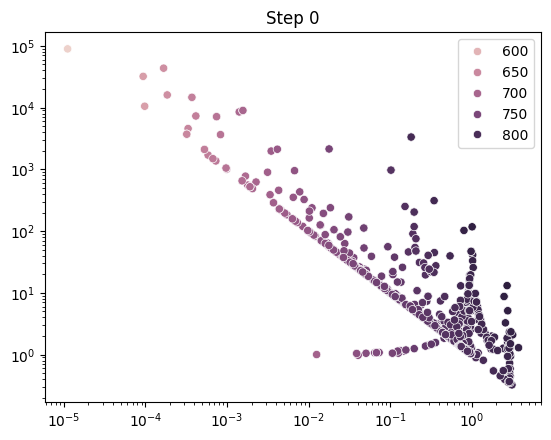

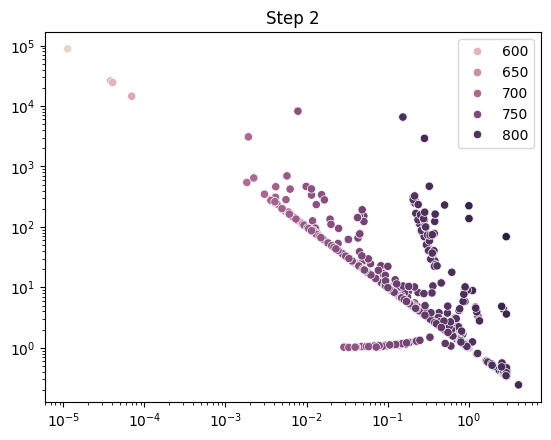

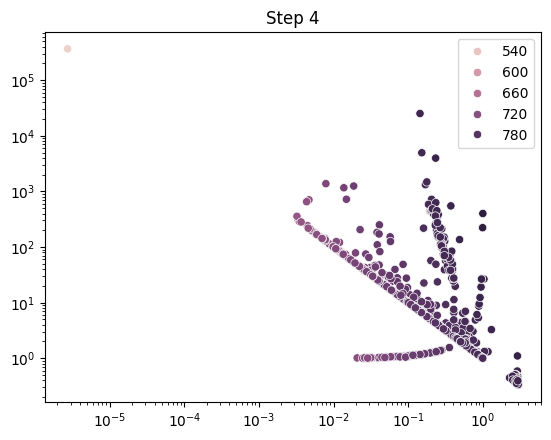

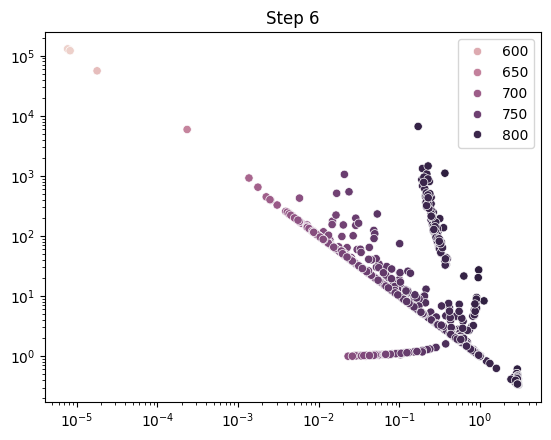

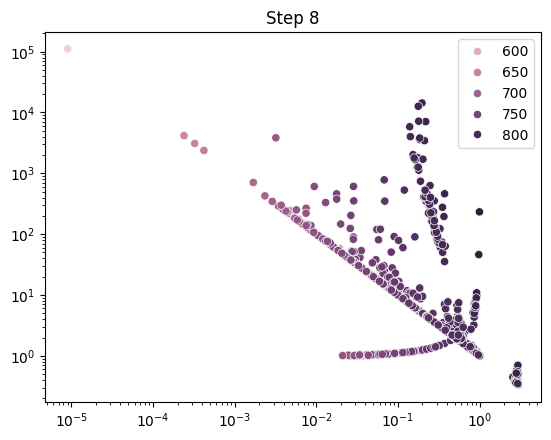

In [8]:
n_samples_per_parent = int(np.ceil(total_samples/choose_max))

# [total_steps, n_outputs, n_samples, n_reactions]
all_params_en = np.zeros((total_steps, *reverse_rates.shape))
all_params_eq = np.zeros((total_steps, *reverse_rates.shape))
all_params_rt = np.zeros((total_steps, *reverse_rates.shape))
all_is_parent = np.zeros((total_steps, total_samples), dtype=bool)
all_adaptability = np.zeros((total_steps, total_samples, len(species)))
all_sensitivity = np.zeros((total_steps, total_samples, len(species)))
all_precision = np.zeros((total_steps, total_samples, len(species)))

sim_func = jax.vmap(partial(bioreaction_sim_dfx_expanded,
                            t0=t0, t1=t1, dt0=dt0,
                            forward_rates=forward_rates,
                            inputs=inputs,
                            outputs=outputs,
                            solver=get_diffrax_solver(sim_method),
                            saveat=dfx.SaveAt(ts=jnp.linspace(t0, t1, 500)),
                            stepsize_controller=make_stepsize_controller(t0, t1, dt0, dt1, choice=stepsize_controller)))

curr_en = energies
for step in range(total_steps):

    print(f'\n\nStarting iteration {step+1} out of {total_steps}\n\n')

    curr_eq = jax.vmap(
        partial(equilibrium_constant_reparameterisation, initial=N0))(curr_en)
    _, curr_rt = eqconstant_to_rates(curr_eq, k_a)

    ys0, ts0, ys1, ts1 = simulate(
        y00, curr_rt, sim_func, t0, t1, tmax, batch_size, threshold_steady_state)
    next_idxs, adaptability, sensitivity, precision = choose_next(sol=(ys0, ys1), idxs_signal=idxs_signal, idxs_output=idxs_output,
                                                                  use_sensitivity_func1=use_sensitivity_func1, choose_max=choose_max, diversity=diversity)
    
    if np.mod(step, 2) == 0:
        plt.figure()
        sns.scatterplot(x=sensitivity[next_idxs].flatten(), y=precision[next_idxs].flatten(), hue=adaptability[next_idxs].flatten())
        plt.xscale('log')
        plt.yscale('log')
        plt.title(f'Step {step}')

    # Save results
    all_params_en[step] = curr_en
    all_params_eq[step] = curr_eq
    all_params_rt[step] = curr_rt
    all_is_parent[step][next_idxs] = True
    all_adaptability[step] = adaptability
    all_sensitivity[step] = sensitivity
    all_precision[step] = precision

    # Mutate energies
    next_en = mutate_expand(
        curr_en[next_idxs], n_samples_per_parent, mutation_scale)[:total_samples]
    curr_en = next_en

# Visualise

Maxima - Adaptability: 844.64990234375, Sensitivity: 7.269807815551758, Precision: inf


Maxima - Adaptability: 845.3756103515625, Sensitivity: 3.868906021118164, Precision: inf


Maxima - Adaptability: 850.2460327148438, Sensitivity: 4.11173677444458, Precision: inf


Maxima - Adaptability: 843.92919921875, Sensitivity: 4.62528133392334, Precision: inf


Maxima - Adaptability: 842.0341796875, Sensitivity: 3.90657639503479, Precision: 2112523.25


Maxima - Adaptability: 831.4229125976562, Sensitivity: 3.3384687900543213, Precision: inf


Maxima - Adaptability: 829.09619140625, Sensitivity: 3.871159076690674, Precision: 813472.0625
Maxima - Adaptability: 832.7117919921875, Sensitivity: 3.6861965656280518, Precision: inf


Maxima - Adaptability: 831.888427734375, Sensitivity: 3.0376384258270264, Precision: 2121449.5
Maxima - Adaptability: 830.99560546875, Sensitivity: 3.381333112716675, Precision: 10163930.0


Text(0.5, 0.98, 'Monte Carlo sampling for higher adaptability')

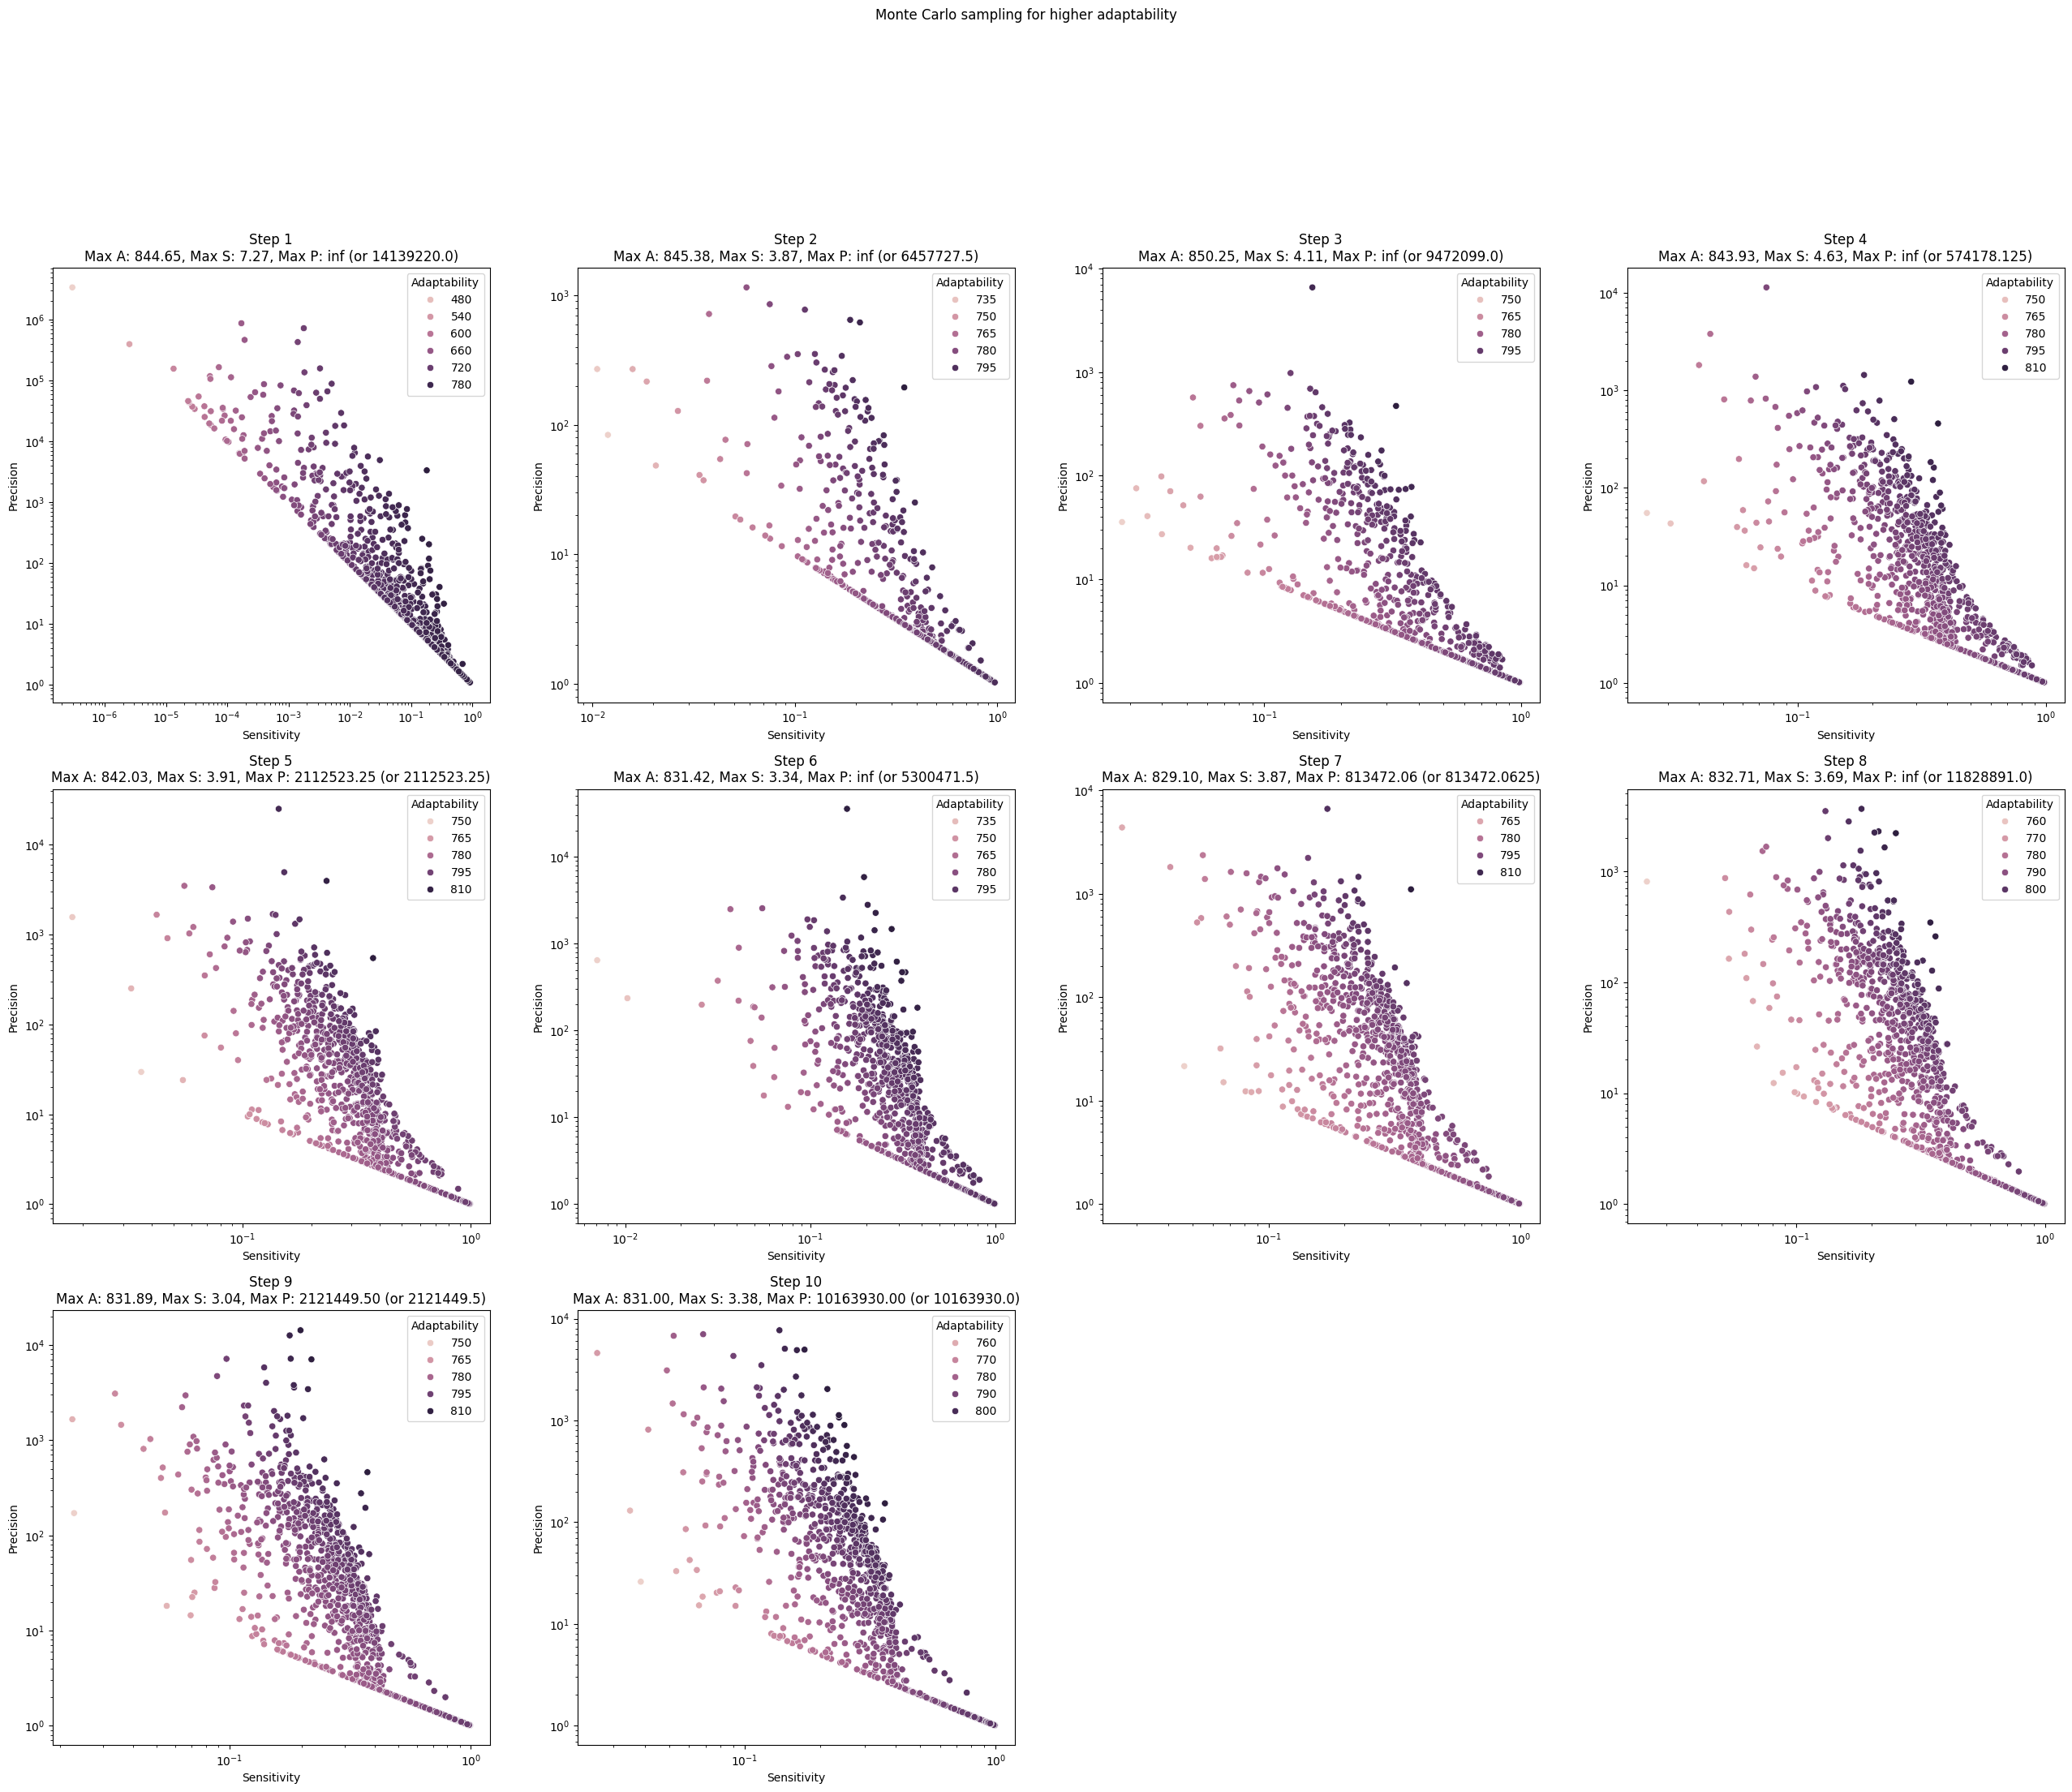

In [9]:
nc = int(np.ceil(np.sqrt(total_steps)))
nr = int(np.ceil(np.sqrt(total_steps)))
plt.figure(figsize=(8*nc, 8*nr))
d = pd.DataFrame(data={'Adaptability': all_adaptability[..., idxs_output].flatten(), 
                       'Sensitivity': all_sensitivity[..., idxs_output].flatten(), 
                       'Precision': all_precision[..., idxs_output].flatten(), 
                       'Is parent circuit': np.repeat(all_is_parent.flatten(), repeats=len(species_output)),
                       'Circuit idx': np.repeat(np.repeat(np.arange(total_samples), repeats=len(species_output)), repeats=total_steps),
                       'Species': flatten_listlike([[s] * total_samples for s in species_output] * total_steps),
                       'Step': np.repeat(np.arange(total_steps), repeats=total_samples*len(species_output)),
                       'Params energy': [l.tolist() for l in np.repeat(all_params_en.flatten(), repeats=len(species_output)).reshape(-1, energies.shape[-1])],
                       'Params equilibrium constants': [l.tolist() for l in np.repeat(all_params_eq.flatten(), repeats=len(species_output)).reshape(-1, energies.shape[-1])],
                       'Params rates': [l.tolist() for l in np.repeat(all_params_rt.flatten(), repeats=len(species_output)).reshape(-1, energies.shape[-1])]})
for step, (a, s, p) in enumerate(zip(all_adaptability, all_sensitivity, all_precision)):
    print(f'Maxima - Adaptability: {jnp.nanmax(a)}, Sensitivity: {jnp.nanmax(s)}, Precision: {jnp.nanmax(p)}')
    
    filt = (d['Step'] == step) & (d['Species'].isin(species_output))
    
    ax = plt.subplot(nr, nc, step+1)
    sns.scatterplot(d[filt], x='Sensitivity', y='Precision', hue='Adaptability')
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'Step {step+1}\nMax A: {jnp.nanmax(a):.2f}, Max S: {jnp.nanmax(s):.2f}, Max P: {jnp.nanmax(p):.2f} (or {jnp.nanmax(p[p < np.inf])})')

plt.suptitle('Monte Carlo sampling for higher adaptability')

Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf
Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf
Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf
Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf
Maxima - Adaptability: 842.0341796875, Sensitivity: 3.90657639503479, Precision: 2112523.25
Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf
Maxima - Adaptability: 829.09619140625, Sensitivity: 3.871159076690674, Precision: 813472.0625
Maxima - Adaptability: nan, Sensitivity: nan, Precision: inf


Maxima - Adaptability: 831.888427734375, Sensitivity: 3.0376384258270264, Precision: 2121449.5
Maxima - Adaptability: 830.99560546875, Sensitivity: 3.381333112716675, Precision: 10163930.0


Text(0.5, 0.98, 'Monte Carlo sampling for higher adaptability')

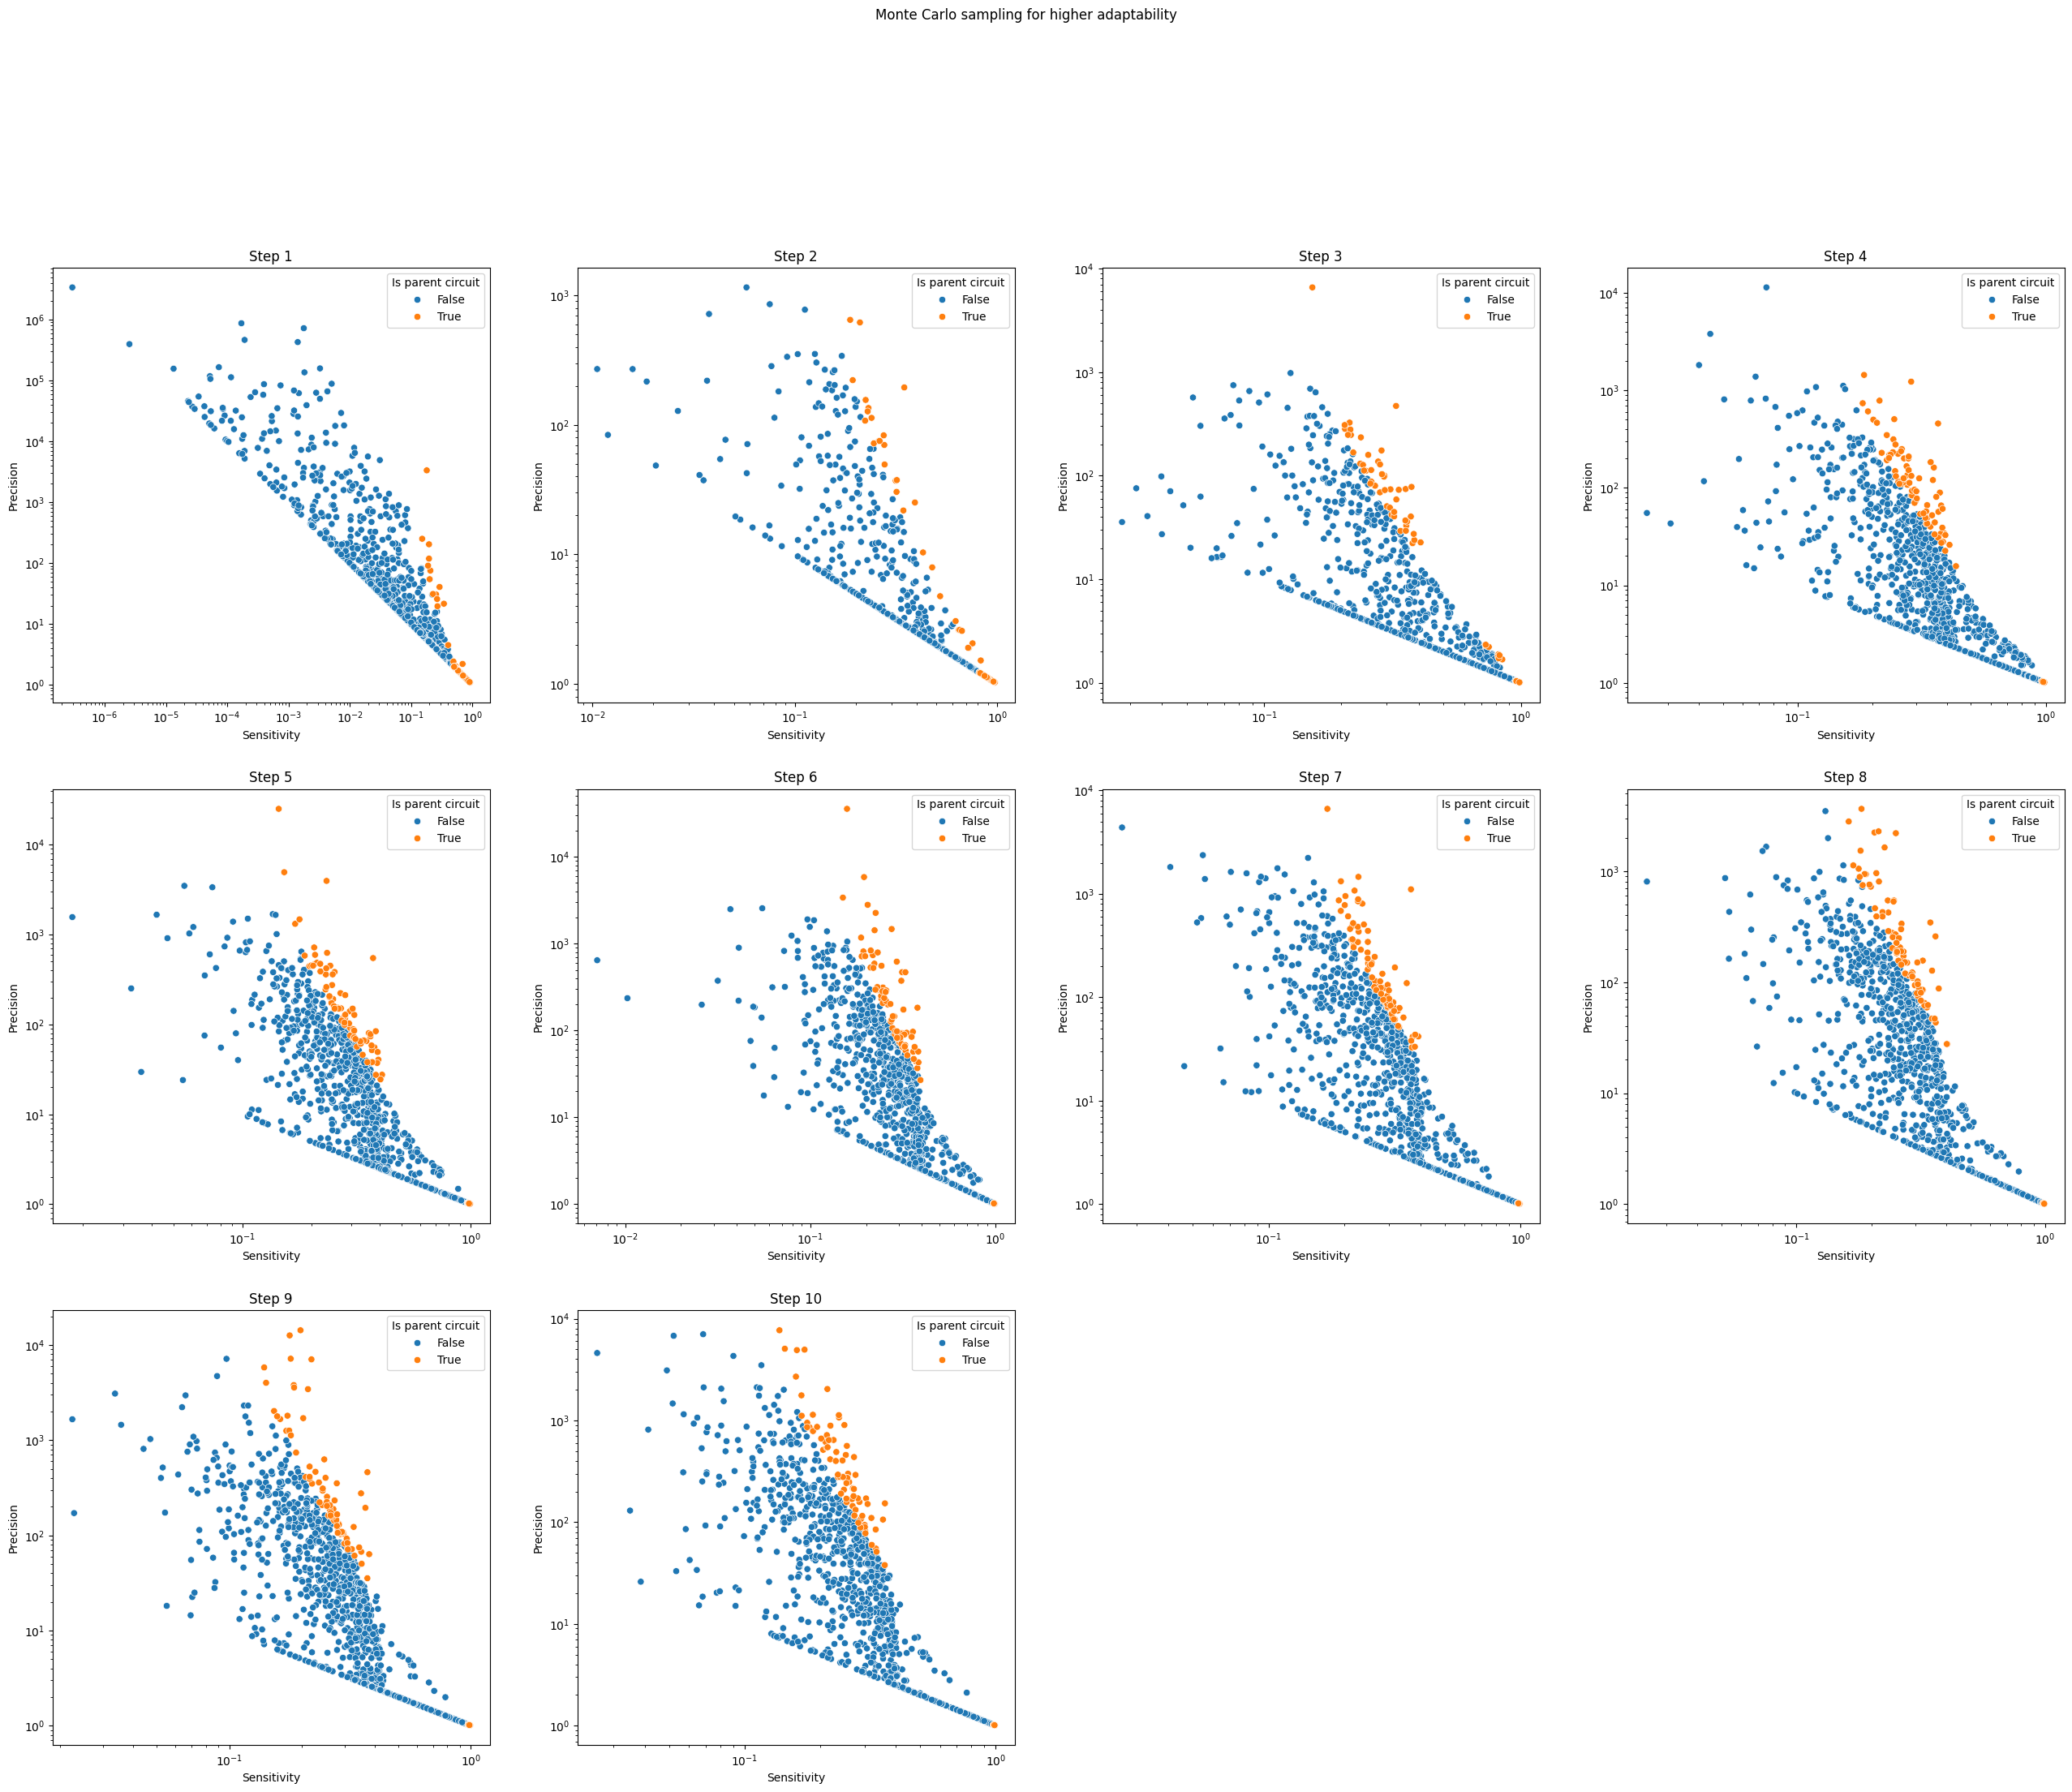

In [10]:
nc = int(np.ceil(np.sqrt(total_steps)))
nr = int(np.ceil(np.sqrt(total_steps)))
plt.figure(figsize=(8*nc, 8*nr))
for step, (a, s, p) in enumerate(zip(all_adaptability, all_sensitivity, all_precision)):
    print(f'Maxima - Adaptability: {a.max()}, Sensitivity: {s.max()}, Precision: {p.max()}')
    
    filt = (d['Step'] == step) & (d['Species'].isin(species_output))
    ax = plt.subplot(nr, nc, step+1)
    sns.scatterplot(d[filt].sort_values(by='Is parent circuit'), x='Sensitivity', y='Precision', hue='Is parent circuit')
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'Step {step+1}')

plt.suptitle('Monte Carlo sampling for higher adaptability')

## Visualise histograms

Text(0.5, 1.0, 'Precision')

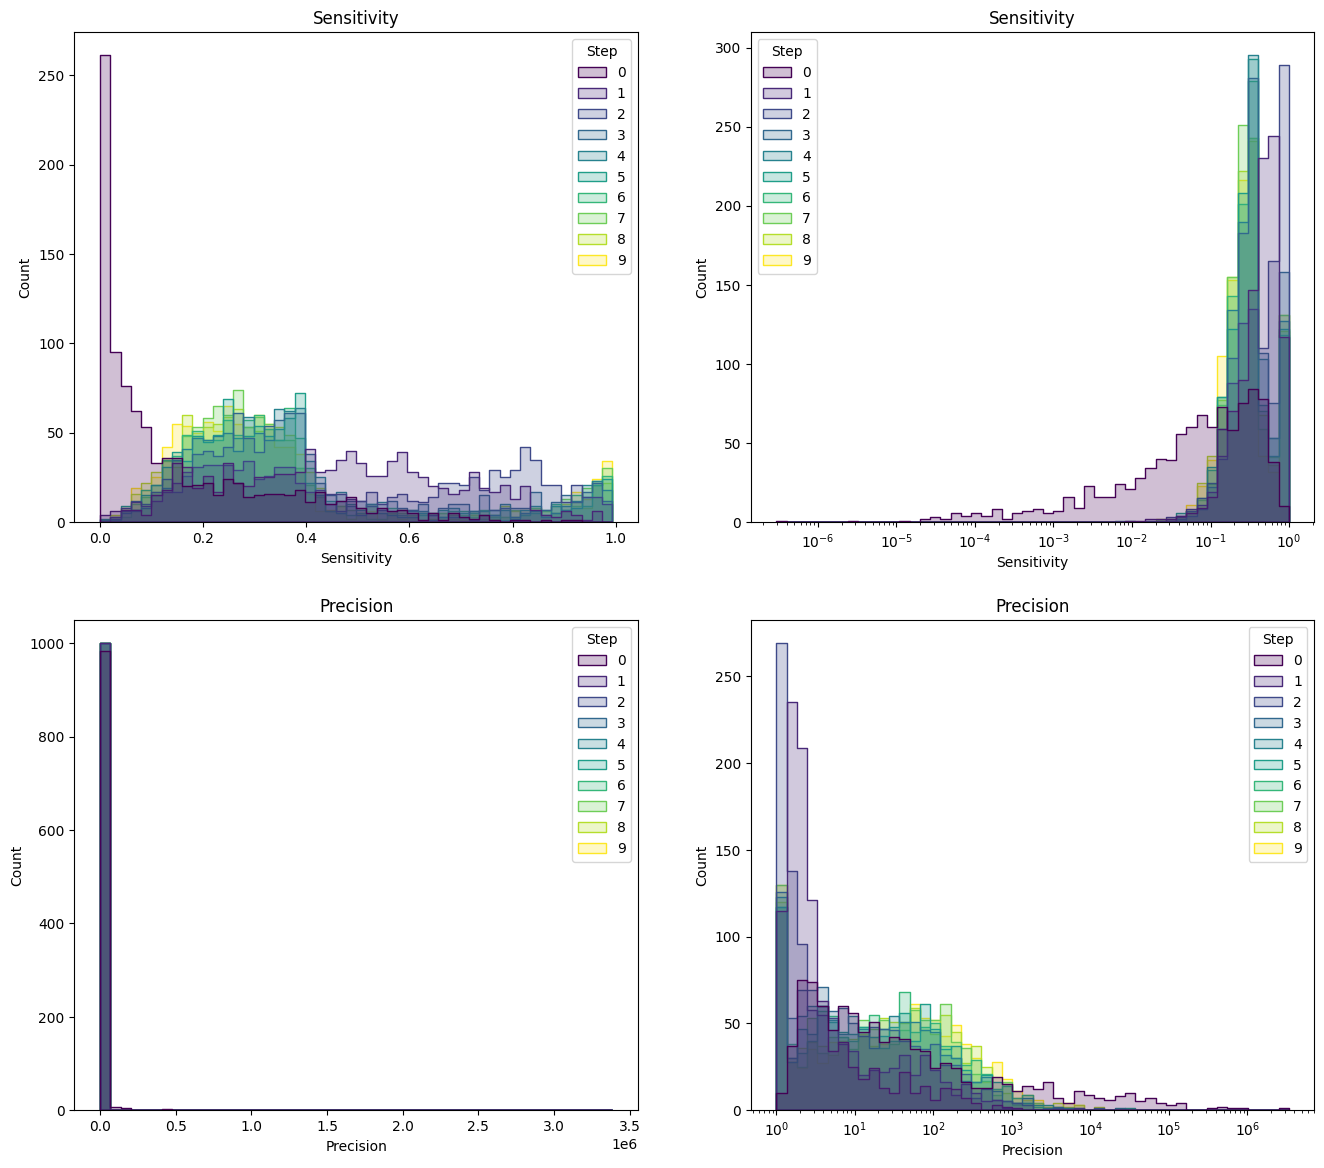

In [11]:
fig = plt.figure(figsize=(8*2, 7*2))
ax = plt.subplot(2, 2, 1)
sns.histplot(d, x='Sensitivity', hue='Step', log_scale=[False, False], bins=50, element='step', palette='viridis')
plt.title('Sensitivity')
ax = plt.subplot(2, 2, 2)
sns.histplot(d, x='Sensitivity', hue='Step', log_scale=[True, False], bins=50, element='step', palette='viridis')
plt.title('Sensitivity')
ax = plt.subplot(2, 2, 3)
sns.histplot(d, x='Precision', hue='Step', log_scale=[False, False], bins=50, element='step', palette='viridis')
plt.title('Precision')
ax = plt.subplot(2, 2, 4)
sns.histplot(d, x='Precision', hue='Step', log_scale=[True, False], bins=50, element='step', palette='viridis')
plt.title('Precision')


In [12]:
d.sort_values(by='Adaptability', ascending=False).head(10)

,Adaptability,Sensitivity,Precision,Is parent circuit,Circuit idx,Species,Step,Params energy,Params equilibrium constants,Params rates
6245,814.308838,0.367287,1107.272339,True,624,RNA_2,6,"[-4.707885265350342, -13.075042724609375, -13....","[7.249382906593382e-05, 0.05852605774998665, 0...","[20.823579788208008, 0.02579331398010254, 0.02..."
4209,811.829041,0.373631,548.539612,True,420,RNA_2,4,"[-3.324798107147217, -10.859965324401855, -13....","[2.3975473595783114e-05, 0.009948384948074818,...","[62.96355438232422, 0.15174131095409393, 0.025..."
8949,811.088928,0.373365,460.818268,True,894,RNA_2,8,"[-2.954153537750244, -8.370862007141113, -12.4...","[1.7823465896071866e-05, 0.001358155393972993,...","[84.6962661743164, 1.1114935874938965, 0.04335..."
3683,810.791687,0.368424,456.531921,True,368,RNA_2,3,"[-4.296269416809082, -9.842735290527344, -12.6...","[5.215441342443228e-05, 0.004408903885632753, ...","[28.944454193115234, 0.3423937261104584, 0.035..."
8372,810.714233,0.197258,14302.009766,True,837,RNA_2,8,"[-4.70148229598999, -14.269174575805664, -9.61...","[7.212341733975336e-05, 0.1521364152431488, 0....","[20.930524826049805, 0.00992254912853241, 0.40..."
8015,810.665894,0.218977,7072.353516,True,801,RNA_2,8,"[-2.9151687622070312, -13.397797584533691, -9....","[1.7276166545343585e-05, 0.07576799392700195, ...","[87.37939453125, 0.019923729822039604, 0.46450..."
4334,810.061401,0.233663,3965.436035,True,433,RNA_2,4,"[-2.377479314804077, -22.06749725341797, -10.0...","[1.1236606951570138e-05, 77.91986846923828, 0....","[134.34490966796875, 1.9373504983377643e-05, 0..."
3221,809.886230,0.286975,1225.997559,True,322,RNA_2,3,"[-3.8802602291107178, -7.200136661529541, -10....","[3.738993837032467e-05, 0.0005323506193235517,...","[40.37398910522461, 2.8356893062591553, 0.2070..."
5597,809.738708,0.274798,1476.395996,True,559,RNA_2,5,"[-4.158820152282715, -13.302316665649414, -10....","[4.672358772950247e-05, 0.0701959952712059, 0....","[32.30875778198242, 0.02150522917509079, 0.292..."
7768,809.422119,0.250954,2203.707764,True,776,RNA_2,7,"[-2.2532660961151123, -18.75720977783203, -10....","[1.0173700502491556e-05, 5.514882564544678, 0....","[148.38072204589844, 0.00027372859767638147, 0..."


In [13]:
d.sort_values(by='Adaptability', ascending=False).to_csv('23_Monte_Carlo_adaptability.csv', index=False)